# Data Wrangling 

## Retrieving books from [Open Library dump](https://openlibrary.org/developers/dumps) and their ratings in [Goodreads](https://www.goodreads.com)

Loading the necessary python packages

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import csv
import json
path='/home/kliton/Documents/Springboard/Capstone/BookRatings/'

Define the paths where to retrieve the datasets from

In [10]:
BookRatings =  pd.read_csv(path + 'goodreadsReviewsDB1.csv')
BookDescr   =  pd.DataFrame() #pd.read_csv(path + 'allDBooks.csv') 

#combine the dataframes from the files
for filenum in range(1, 6):
    dfbooks = pd.read_csv(path + 'goodreadsTransfDB' + str(filenum)+'.csv')
    BookDescr = pd.DataFrame.append(BookDescr, dfbooks)

Calculate the number of rows in dataset

In [11]:
print('Length of OL dump: '+ str(len(BookDescr)) +', respective Goodreads ratings:' + str(len(BookRatings)))

Length of OL dump: 20005, respective Goodreads ratings:18001


The structure from the dump table:

In [12]:
BookDescr.head()

,Unnamed: 0,authors,by_statement,classifications.udc,contributions,contributors,copyright_date,coverimage,covers,create,...,translated_from,translation_of,type.key,uri_descriptions,uris,url,weight,work_title,work_titles,works
0,0,NaN,edited by Stephanie Newell.,NaN,"['Newell, Stephanie, 1968-']",NaN,NaN,NaN,"[4872475, 4872461, 3858348, 3858328]",NaN,...,NaN,NaN,/type/edition,"['Publisher description', 'Table of contents']",['http://www.loc.gov/catdir/description/hol055...,['http://www.loc.gov/catdir/description/hol055...,NaN,NaN,NaN,NaN
1,0,[{'key': '/authors/OL230045A'}],Mario Bencastro.,NaN,NaN,NaN,NaN,NaN,[1882676],NaN,...,NaN,NaN,/type/edition,NaN,NaN,NaN,NaN,NaN,NaN,[{'key': '/works/OL1919075W'}]
2,0,[{'key': '/authors/OL541207A'}],Mina Kumar.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,/type/edition,NaN,NaN,NaN,NaN,NaN,NaN,[{'key': '/works/OL3338418W'}]
3,0,[{'key': '/authors/OL244070A'}],by Robb Armstrong.,NaN,NaN,NaN,NaN,NaN,"[3857941, 3857863]",NaN,...,NaN,NaN,/type/edition,NaN,NaN,NaN,NaN,NaN,NaN,[{'key': '/works/OL2021805W'}]
4,0,[{'key': '/authors/OL24054A'}],Sandra Belton.,NaN,NaN,NaN,NaN,NaN,[3857889],NaN,...,NaN,NaN,/type/edition,NaN,NaN,NaN,NaN,NaN,NaN,[{'key': '/works/OL16070305W'}]


There are 82 columns. Let's have a look at all of them:

In [15]:
BookDescr.columns

Index(['Unnamed: 0', 'authors', 'by_statement', 'classifications.udc',
       'contributions', 'contributors', 'copyright_date', 'coverimage',
       'covers', 'create', 'created.type', 'created.value', 'description',
       'description.type', 'description.value', 'dewey_decimal_class',
       'edition_name', 'first_sentence', 'first_sentence.type',
       'first_sentence.value', 'full_title', 'genres', 'ia_box_id',
       'ia_loaded_id', 'identifiers.amazon', 'identifiers.amazon.co.uk_asin',
       'identifiers.bodleian,_oxford_university',
       'identifiers.british_library', 'identifiers.goodreads',
       'identifiers.google', 'identifiers.librarything', 'identifiers.oclc',
       'identifiers.shelfari', 'isbn_10', 'isbn_13', 'isbn_invalid', 'key',
       'languages', 'last_modified.type', 'last_modified.value',
       'latest_revision', 'lc_classifications', 'lccn', 'links', 'location',
       'notes', 'notes.type', 'notes.value', 'number_of_pages', 'ocaid',
       'oclc_number'

The identifier columns do not give us much information. We can drop this information:

In [17]:
BookDescr.drop([item for l in filter(None, BookDescr.columns.str.findall('identi.*')) for item in l], axis=1, inplace=True)

The ratings table has the following columns:

In [14]:
BookRatings.head()

,Unnamed: 0,average_rating,id,isbn,isbn13,ratings_count,reviews_count,text_reviews_count,work_ratings_count,work_reviews_count,work_text_reviews_count
0,0,3.0,5082313,1856494497,9.781856e+12,2,3,0,2,3,0
1,1,3.0,1271896,1856494500,9.781856e+12,0,0,0,2,3,0
2,2,3.8,1466769,1558851941,9.781559e+12,9,24,0,15,35,1
3,3,4.0,2172988,60275278,9.780060e+12,0,1,0,1,7,0
4,4,4.0,611491,64420477,9.780064e+12,1,6,0,1,7,0


The *isbn* column holds values of integer types. It is necessary to convert that column to 0 left padded string:

In [18]:
BookRatings['isbn10'] = BookRatings.isbn.apply(lambda x: str(x).zfill(10) )

With this new column we can calculate an average rating for several ISBNs for a literature work (there can be several editions for a book and also there can be a collection of works). First, we need to convert the *isbn* column contents to a list. The raw format is "['isbn1', 'isbn2'...]"

In [22]:
BookDescr['isbn10'] = BookDescr.isbn_10.apply(lambda x: eval(str(x)) if type(x)==str else '')

The average rating columns is appended to the main table by matching the isbn numbers:

In [23]:
BookDescr['average_rating'] = BookDescr.isbn10.apply(lambda x: BookRatings[BookRatings.isbn10.isin(x if type(x)=='list' else list(x))].average_rating.mean())

We can calculate the standard deviation of the average book rating by getting the rating for different isbn for a specific literature work. This is not the standard deviation from users' rating, though.

In [25]:
BookDescr['average_rating_sd'] = BookDescr.isbn10.apply(lambda x: BookRatings[BookRatings.isbn10.isin(x if type(x)=='list' else list(x))].average_rating.std())

In [27]:
BookDescr.average_rating.notnull().value_counts()

True     16328
False     3677
Name: average_rating, dtype: int64

There are 3,677 books that we cannot find a rating in Goodreads. Those won't be considered in this project.

In [31]:
BkDescNnullAvg = BookDescr[BookDescr.average_rating.notnull()]

Let's have a look at the histogram of the average ratings in the last dataset:

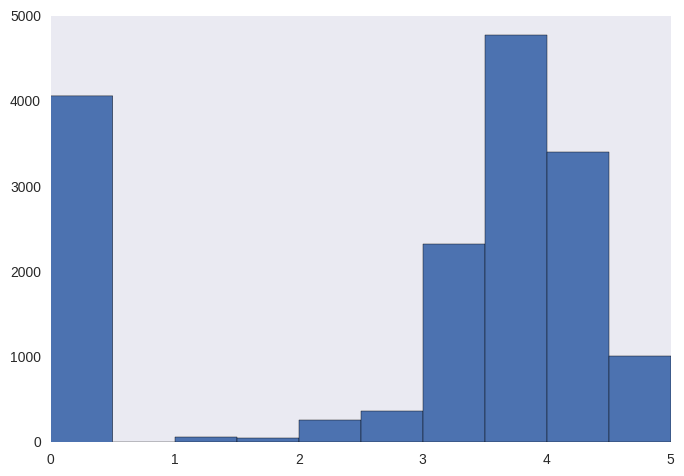

In [32]:
BkDescNnullAvg.average_rating.hist(grid=False);

There are a lot of books with a 0 rating. Verifying some of the records in Goodreads, those books also seem to be unrated yet. Will retain only those records that have a rating.

In [33]:
BkDescNonZeroRating = BkDescNnullAvg[BkDescNnullAvg.average_rating > 0]

Let's visualize the missing records in each of the columns. We need to transform our dataset first.

In [61]:
BkValRatio = BkDescNonZeroRating[BkDescNonZeroRating.columns[1:63]].notnull()
newDF = pd.DataFrame()
for i in BkValRatio.columns:
    newDF = pd.DataFrame.append(newDF, BkValRatio[i].value_counts().sort_index()) 
newDF.fillna(0,  inplace=True)
newDF['Total'] = newDF[0]+newDF[1]
newDF['Category']=newDF.index
newDF['Empty'] = newDF[0]
newDF

,False,True,Total,Category,Empty
authors,799.0,11466.0,12265.0,authors,799.0
by_statement,659.0,11606.0,12265.0,by_statement,659.0
contributions,8634.0,3631.0,12265.0,contributions,8634.0
contributors,12247.0,18.0,12265.0,contributors,12247.0
coverimage,12263.0,2.0,12265.0,coverimage,12263.0
covers,5301.0,6964.0,12265.0,covers,5301.0
created.type,561.0,11704.0,12265.0,created.type,561.0
created.value,561.0,11704.0,12265.0,created.value,561.0
description,12219.0,46.0,12265.0,description,12219.0
description.type,9873.0,2392.0,12265.0,description.type,9873.0


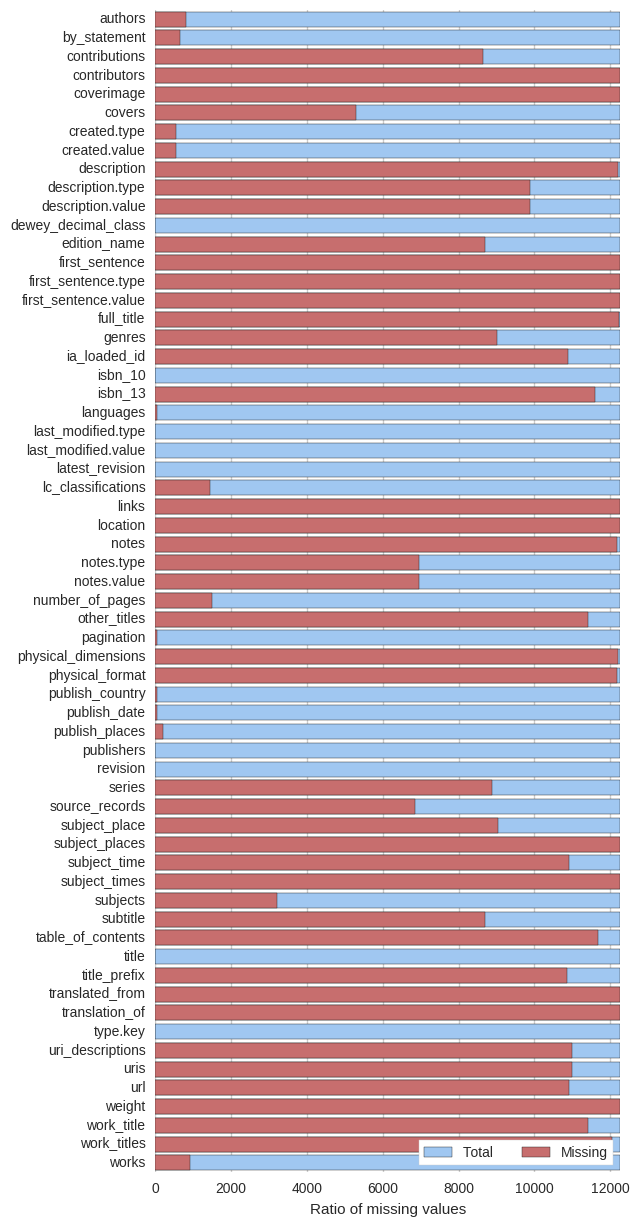

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))


# Plot the total records
sns.set_color_codes("pastel")
sns.barplot(x="Total", y="Category", data=newDF,
            label="Total", color="b")

# Plot missing values
sns.set_color_codes("muted")
sns.barplot(x="Empty", y="Category", data=newDF,
            label="Missing", color="r")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, newDF.Total[0]), ylabel="",
       xlabel="Ratio of missing values")
sns.despine(left=True, bottom=True)

The above chart visualizes the rate of missing vs existing values for each column in the table.

We can remove some of the classification columns:

In [56]:
columns2remove = ['ocaid', 'classifications.udc', 'create', 'isbn_invalid', 'copyright_date', 'key', 'lccn', 'ia_box_id', 'oclc_number', 'oclc_numbers']

BkDescNonZeroRating.drop(columns2remove, inplace=True, axis=1)

/home/kliton/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [67]:
BkDescNonZeroRating.coverimage.value_counts()

/static/images/book.trans.gif                                    1
/static/files//563/OL2839307M_coverimage_1218051658274563.jpg    1
Name: coverimage, dtype: int64

In [648]:
def getFirstDeweyGroup(dewey_class):
    val = re.findall('8[0-9]{2}', dewey_class) if '8' in dewey_class else dewey_class
    if type(val) == list and len(val) > 0:
        return val[0]
    # E is mainly educational for little kids
    if 'E' in dewey_class:
        return 'Educational'
    # Fic is for fictional
    if 'F' in dewey_class:
        return 'Fictional'
    return eval(dewey_class)[0]

In [649]:
DeweyParsed = BkDescNonZeroRating.dewey_decimal_class.apply(lambda x: getFirstDeweyGroup(x))
#re.findall('8[0-9]{2}', DeweyParsed.iloc[22]) if '8' in DeweyParsed.iloc[22] else DeweyParsed.iloc[22]
#DeweyParsed.iloc[0][0]

In [651]:
len(DeweyParsed.value_counts())

83

In [652]:
BkDescNonZeroRating['dewey_parsed'] = DeweyParsed

/home/kliton/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [654]:
BkDescNonZeroRating.dewey_parsed.value_counts().head(10)

813            3530
823            2200
Educational    1258
Fictional      1192
811             654
808             384
821             361
822             243
843             236
891             172
Name: dewey_parsed, dtype: int64

### Authors data

In [69]:
AuthorDFDump = pd.read_csv('/home/kliton/Downloads/ol_dump_authors_2017-01-31.txt', sep='\t', header=None)

In [70]:
AuthorDFDump.head()

,0,1,2,3,4
0,/type/author,/authors/OL1000057A,2,2008-08-20T17:57:09.66187,"{""name"": ""Kha\u0304lid Muh\u0323ammad \u02bbAl..."
1,/type/author,/authors/OL100029A,2,2008-09-08T16:19:17.29978,"{""name"": ""K. Hardono"", ""personal_name"": ""K. Ha..."
2,/type/author,/authors/OL1000624A,2,2008-08-20T17:58:34.686964,"{""name"": ""Nu\u0304r al-Di\u0304n S\u0323ammu\u..."
3,/type/author,/authors/OL1000703A,2,2008-08-20T17:58:45.326121,"{""name"": ""Mawlu\u0304d Qa\u0304sim Na\u0304yit..."
4,/type/author,/authors/OL1001014A,2,2008-08-20T17:59:35.453547,"{""name"": ""Ali Ak"", ""personal_name"": ""Ali Ak"", ..."


In [71]:
from pandas.io.json import json_normalize
#AuthorDF[AuthorDF[1] == '/authors/OL1000057A'][4][0]

In [148]:
AuthorDFDump = AuthorDFDump[AuthorDFDump[1].isin(
    filter(None, [(eval(i)[0]['key'] if type(i)==str else'') for i in BkDescNonZeroRating.authors]))]


In [166]:
AuthorsDF = pd.DataFrame() 
for record in AuthorDFDump[4]:
    AuthorsDF = pd.DataFrame.append(AuthorsDF, json_normalize(json.loads(record)))
AuthorsDF.head()

,alternate_names,bio,bio.type,bio.value,birth_date,comment,created.type,created.value,date,death_date,...,personal_name,photograph,photos,revision,role,tags,title,type.key,website,wikipedia
0,[Strong Jeremy],NaN,NaN,NaN,1949,NaN,/type/datetime,2008-04-01T03:28:50.625462,NaN,NaN,...,Jeremy Strong,NaN,NaN,3,NaN,NaN,NaN,/type/author,NaN,NaN
0,NaN,NaN,NaN,NaN,1943,NaN,NaN,NaN,NaN,NaN,...,Sylvia Kasey Marks,NaN,NaN,2,NaN,NaN,NaN,/type/author,NaN,NaN
0,NaN,NaN,NaN,NaN,1878,NaN,/type/datetime,2008-04-01T03:28:50.625462,NaN,1956,...,Aino Krohn Kallas,NaN,NaN,3,NaN,NaN,NaN,/type/author,NaN,NaN
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"Berckman, Evelyn.",NaN,NaN,1,NaN,NaN,NaN,/type/author,NaN,NaN
0,"[Waugh/Evelyn, Evelyn. Waugh]",NaN,NaN,NaN,1903,NaN,/type/datetime,2008-04-01T03:28:50.625462,NaN,1966,...,Evelyn Waugh,NaN,NaN,3,NaN,NaN,NaN,/type/author,NaN,NaN


In [175]:
AuthorsDF.birth_date.value_counts().head()

1949    84
1940    80
1947    77
1942    75
1952    73
Name: birth_date, dtype: int64

In [171]:
AuthorsDF['wikipedia'].notnull().value_counts()

False    8563
True      180
Name: wikipedia, dtype: int64

In [267]:
from datetime import datetime
from dateutil.parser import parse
import re

In [496]:
def parseDate(datestr):
    retVal = ''
    #most likely not a valid date
    if len(str(datestr)) < 4:
        return retVal
    
    # retrieve B.C. years
    if len(re.findall('(B.\s*C.)|(b.\s*c.)', str(datestr))) > 0:
        yearValue = re.findall('\d*', str(datestr))
        if len(yearValue) > 0:
            nonEmpty = list(filter(None, yearValue))
            return -int(nonEmpty[0])
    if 'cent' in datestr:
        centList = re.findall('\d*', str(datestr))
        century = list(filter(None, centList))
        return int(century[0])
    # removing dots as it can cause the parsing to fail
    datestr = datestr.replace('.', '')
    
    # will try parsing out a date from timedate string
    try:
        retVal = parse(datestr, fuzzy=True) if type(datestr)==str else ''
    except ValueError:
        # will try to find the first 4 number to define a year
        regexVal = re.findall('\d{4}',str(datestr))
        if len(regexVal) > 0:
            return parse(regexVal[0], fuzzy=True)
    return retVal
            


In [467]:
AuthorsDF['birthdate_parsed'] = AuthorsDF.birth_date.apply(lambda x: parseDate(x))

In [298]:
AuthorsDF.alternate_names.apply(lambda x: ' '.join(x) if type(x)==list else x).head()

0                 Strong Jeremy
0                           NaN
0                           NaN
0                           NaN
0    Waugh/Evelyn Evelyn. Waugh
Name: alternate_names, dtype: object

In [425]:
AuthorsDF.columns

Index(['alternate_names', 'bio', 'bio.value', 'birth_date', 'created.type',
       'created.value', 'date', 'death_date', 'entity_type', 'fuller_name',
       'key', 'last_modified.value', 'latest_revision', 'links', 'location',
       'name', 'personal_name', 'revision', 'tags', 'title', 'website',
       'wikipedia', 'birthdate_parsed', 'deathdate_parsed'],
      dtype='object')

In [382]:
AuthorsDF['deathdate_parsed'] = AuthorsDF.death_date.apply(lambda x: parseDate(x))

In [443]:
type(parse('1860').year)

int

In [468]:
AuthorsDF['age'] = abs(AuthorsDF.deathdate_parsed.apply(lambda x: x.year if type(x)==datetime else int(x if type(x)==str and x!='' else 2017) ) - AuthorsDF.birthdate_parsed.apply(lambda x: x.year if type(x)==datetime else int(x if type(x)==str and x!='' else 0))) #(AuthorsDF.deathdate_parsed.diff - AuthorsDF.birthdate_parsed.year).head()

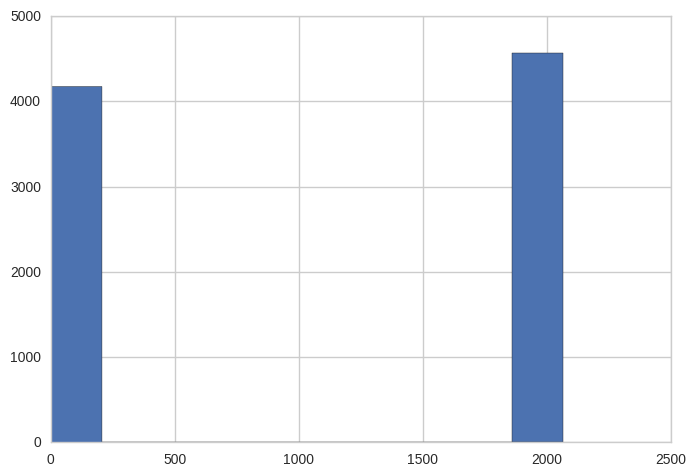

In [475]:
AuthorsDF.age.hist()


In [474]:
AuthorsDF[(AuthorsDF.age < 14)]

,alternate_names,bio,bio.value,birth_date,created.type,created.value,date,death_date,entity_type,fuller_name,...,name,personal_name,revision,tags,title,website,wikipedia,birthdate_parsed,deathdate_parsed,age
0,NaN,NaN,NaN,2nd/3rd cent.,NaN,NaN,NaN,NaN,NaN,NaN,...,Philostratus the Athenian,Philostratus,1,NaN,the Athenian,NaN,NaN,2017-02-03 00:00:00,,0
0,NaN,NaN,NaN,16th cent.,NaN,NaN,NaN,NaN,NaN,NaN,...,"Zapata, Luis","Zapata, Luis",1,NaN,NaN,NaN,NaN,2017-03-16 00:00:00,,0
0,"[Valerius Flaccus, Gaius, 1st century.]",NaN,NaN,1st cent.,/type/datetime,2008-04-01T03:28:50.625462,NaN,NaN,NaN,NaN,...,Gaius Valerius Flaccus,Gaius Valerius Flaccus,3,NaN,NaN,NaN,NaN,2017-03-01 00:00:00,,0
0,NaN,NaN,NaN,14th cent.,NaN,NaN,NaN,NaN,NaN,NaN,...,Dafydd ap Gwilym,Dafydd ap Gwilym,1,NaN,NaN,NaN,NaN,2017-03-14 00:00:00,,0
0,[EOIN COLFER],NaN,NaN,"May 14,1965",/type/datetime,2008-04-01T03:28:50.625462,NaN,NaN,NaN,NaN,...,Eoin Colfer,Eoin Colfer,5,NaN,NaN,NaN,NaN,2017-05-14 00:00:00,,0
0,NaN,NaN,NaN,13th cent.,NaN,NaN,NaN,NaN,NaN,NaN,...,Stricker,Stricker,1,NaN,NaN,NaN,NaN,2017-03-13 00:00:00,,0
0,NaN,NaN,NaN,13th cent.,NaN,NaN,NaN,NaN,NaN,NaN,...,Gottfried von Strassburg,Gottfried,1,NaN,von Strassburg,NaN,NaN,2017-03-13 00:00:00,,0
0,[Charlotte Boyett-Compo],NaN,Charlotte Boyett-Compo was born on June 20th a...,20 June,/type/datetime,2008-04-01T03:28:50.625462,NaN,NaN,NaN,NaN,...,Charlotte Boyett-Compo,Charlotte Boyett-Compo,5,NaN,NaN,NaN,NaN,2017-06-20 00:00:00,,0


In [473]:
parseDate('16th cent.')

datetime.datetime(2017, 3, 16, 0, 0)

The ages of writers should be handled properly. There are a lot of outliers because of the poor data entry and parsing. The parsing should handle more specific cases. Especially as the one above where the date is specified by centure. We can find the following information from Wikipedia (https://en.wikipedia.org/wiki/Life_expectancy). It gives us enough information to build this lookup table:

In [526]:
LookupAges = [(0, 35), (5, 47.5), (13, 64), (14, 45), (15, 69), (16,71), (21,71)]

in the above dictionary, we are setting the key as the upper bound for the century and the life expectancy as its corresponding value. 

After making changes to the *parseDate* function we check it:

In [499]:
parseDate('2nd/3rd cent.')

2

Let's apply the function to all the rows that contain birthdate in centuries:

In [546]:
AuthorsDF.birthdate_parsed[AuthorsDF.birth_date.notnull() & AuthorsDF.birth_date.str.contains('cent')]=AuthorsDF.birth_date[AuthorsDF.birth_date.notnull() & AuthorsDF.birth_date.str.contains('cent')].apply(lambda bd: parseDate(bd))

/home/kliton/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [547]:
AuthorsDF.birthdate_parsed[AuthorsDF.birth_date.notnull() & AuthorsDF.birth_date.str.contains('cent')]

0     2
0    -8
0    16
0     1
0    14
0    13
0    13
Name: birthdate_parsed, dtype: object

We see that the dates are converted to integers corresponding to centuries. Now, we can convert those values to age according to the lookup table:

In [549]:
AuthorsDF.age[AuthorsDF.birth_date.notnull() & AuthorsDF.birth_date.str.contains('cent')]=AuthorsDF.birthdate_parsed[AuthorsDF.birth_date.notnull() & AuthorsDF.birth_date.str.contains('cent')].apply(lambda bd: LookupAges[bisect.bisect_left([x[0] for x in LookupAges], bd)][1])

/home/kliton/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [551]:
AuthorsDF.age[AuthorsDF.birth_date.notnull() & AuthorsDF.birth_date.str.contains('cent')]

0    47.5
0    35.0
0    71.0
0    47.5
0    45.0
0    64.0
0    64.0
Name: age, dtype: float64

There are still a lot of records that do not contain a valid value for the age column, because there is no birth date in the records:

In [656]:
len(AuthorsDF[AuthorsDF.age > 150])

4570

In [658]:
AuthorsDF.loc[AuthorsDF.age > 150, 'age'] = pd.np.NaN

In [661]:
BkDescNonZeroRating.languages.value_counts()

[{'key': '/languages/eng'}]                               11587
[{'key': '/languages/spa'}]                                 231
[{'key': '/languages/fre'}]                                 182
[{'key': '/languages/ger'}]                                  90
[{'key': '/languages/ita'}]                                  47
[{'key': '/languages/por'}]                                  32
[{'key': '/languages/lat'}]                                   8
[{'key': '/languages/rus'}]                                   8
[{'key': '/languages/dut'}]                                   5
[{'key': '/languages/swe'}]                                   3
[{'key': '/languages/cat'}]                                   3
[{'key': '/languages/wel'}]                                   2
[{'key': '/languages/gag'}]                                   2
[{'key': '/languages/grc'}]                                   2
[{'key': '/languages/ang'}]                                   2
[{'key': '/languages/gle'}]             

In [663]:
LangCount =  BkDescNonZeroRating['languages'].value_counts()
LangCGT3 = LangCount[LangCount > 3]
BkDescNonZeroRating = BkDescNonZeroRating[BkDescNonZeroRating.languages.isin(LangCGT3.index)]

In [664]:
AuthorsDF.to_csv(path+'AuthorsProcessed.csv')
BkDescNonZeroRating.to_csv(path+'BkProcessed.csv')